# Grid Optimization Analysis

In [1]:
import matplotlib.cm
import math
import numpy as np
import qcportal as ptl
from IPython.display import display, HTML
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.offsetbox import AnnotationBbox, DrawingArea, TextArea
from sklearn import decomposition # PCA
from sklearn.cluster import AgglomerativeClustering
from tqdm.notebook import tqdm, trange

# Local
from util import calc_improper_01

## Loading the Data

In [114]:
CLIENT = ptl.FractalClient()
DATASET = CLIENT.get_collection('GridOptimizationDataset',
                                'OpenFF Trivalent Nitrogen Set 1 (deprecated)')
MOLECULE_IDS = [
    DATASET.get_entry(index).initial_molecule for index in DATASET.df.index
]
MOLECULES = CLIENT.query_molecules(id=MOLECULE_IDS)
METADATA_ENTRIES = [
    DATASET.get_entry(index).object_map['default'] for index in DATASET.df.index
]
# Get all grid optimization calculations from the entire dataset
ENTRIES = CLIENT.query_procedures(METADATA_ENTRIES)

# Number of molecules in the dataset
NUM_ENTRIES = len(ENTRIES)

# (Expected) number of optimization frames
NUM_FRAMES = 21

# The intended improper angle for the trivalent nitrogen in each
# optimization frame
IMPROPER_ANGLE_FOR_FRAME = 4 * (np.arange(0,NUM_FRAMES,1) - NUM_FRAMES // 2)
DEG_BTWN_FRAMES = 4 # Difference in improper angle between frames

# Tells whether the entry at the given index is okay to use
IS_GOOD_ENTRY = np.ones(NUM_ENTRIES, dtype=bool)

def mark_bad_indices(indices):
    """Marks the given indices in IS_GOOD_ENTRY as bad."""
    for idx in indices:
        IS_GOOD_ENTRY[idx] = False

In [115]:
# Remove molecules that have no optimizations
for idx, entry in enumerate(ENTRIES):
    final_energies = entry.get_final_energies()
    if len(final_energies) != NUM_FRAMES:
        print(f"Molecule {idx:3} ({MOLECULES[idx].get_molecular_formula()}) has {len(final_energies)} frames")
        IS_GOOD_ENTRY[idx] = False

Molecule  66 (C22Cl2H24NO6PS) has 0 frames
Molecule  83 (C16H37NO2P2S2) has 0 frames
Molecule  84 (C22H24NO2PS) has 0 frames
Molecule 157 (C31H45N3O8S3) has 0 frames
Molecule 160 (C21H22N2O6S2) has 0 frames
Molecule 175 (C28H22NO2P) has 0 frames
Molecule 193 (C22H24N6O6S2) has 0 frames
Molecule 204 (C12H21N2P) has 0 frames
Molecule 218 (BrC9H8N3) has 0 frames
Molecule 236 (C6H5N3) has 0 frames
Molecule 242 (C13H18N3O2) has 0 frames
Molecule 252 (C24H20NOP) has 0 frames
Molecule 277 (C12H11N2O3S) has 0 frames
Molecule 279 (C10H8N2O2) has 0 frames
Molecule 286 (C7H4INO3S) has 0 frames


In [116]:
print(f"There are currently {sum(IS_GOOD_ENTRY)} good molecules.")

There are currently 296 good molecules.


In [117]:
# Entry i is a 21-dim vector telling the minimized energy in kcal/mol
# of the molecule at frame 0,1,... - these frames correspond to setting
# the improper angle around the trivalent nitrogen in the molecule
# to -40,-36,...,40 degrees
ENERGIES = np.zeros(shape=(NUM_ENTRIES, NUM_FRAMES))

KCAL_MOL_PER_HARTREE = 627.509 # The energies are initially in Hartree

for idx, entry in enumerate(ENTRIES):
    if not IS_GOOD_ENTRY[idx]: continue
    
    # The energies are initially stored in |final_energies| with
    # tuple keys - e.g. frame 0 is (0,)
    final_energies = entry.get_final_energies()
    for frame_idx in range(NUM_FRAMES):
        ENERGIES[idx][frame_idx] = final_energies[(frame_idx,)]
    
    # Convert units
    ENERGIES[idx] *= KCAL_MOL_PER_HARTREE
        
    # Normalize the energies for this molecule by subtracting the
    # minimum energy
    min_energy = np.min(ENERGIES[idx])
    ENERGIES[idx] -= min_energy

In [8]:
# Retrieve the fitted molecule associated with each optimization frame.
# Retrieing each molecule may take a while depending on download
# speeds...
FITTED_MOLECULES = [[None for i in range(NUM_FRAMES)] \
                     for j in range(NUM_ENTRIES)]

for idx, entry in tqdm(tuple(enumerate(ENTRIES))):
    if not IS_GOOD_ENTRY[idx]: continue

    final_molecules = entry.get_final_molecules()
    for frame_idx in range(NUM_FRAMES):
        FITTED_MOLECULES[idx][frame_idx] = final_molecules[(frame_idx,)]

## Utilities

In [118]:
def plot_1d_scan(ax, energies, index):
    """
    Plots a 1D scan consisting of the given energies onto the
    given Axis object. Labels it with the given index.
    """
    ax.plot(IMPROPER_ANGLE_FOR_FRAME, energies)
    ax.set_title(f"Molecule {index} | {MOLECULES[index].get_molecular_formula()}")
    ax.set_xticks(IMPROPER_ANGLE_FOR_FRAME[0::2]) # Ticks are every other value in the ideal impropers
    ax.set_ylabel("kcal/mol")
    
def plot_scans(energies, indices):
    """Plots the 1D scans represented by the (n, 21) energies array.
    
    Each item in energies is identified by the index in the (n, 1)
    indices array.
    """
    COLS = 4
    FIG_WIDTH = 13
    PLOT_HEIGHT = 3
    %matplotlib inline
    
    n = len(energies)
    rows = math.ceil(n / COLS)
    fig, ax = plt.subplots(rows, COLS, figsize=(FIG_WIDTH, PLOT_HEIGHT * rows))
    fig.tight_layout() # Improve spacing between plots
    ax = np.atleast_2d(ax)

    idx = 0
    for r in range(rows):
        for c in range(COLS):
            if idx < n:
                plot_1d_scan(ax[r,c], energies[idx], indices[idx])
            idx += 1
    plt.show()

## Cleaning

Look for irregularities in the data. Irregular molecules are marked by setting their index to `False` in `IS_GOOD_ENTRY`

### Improper Angle Tolerance

Look for grid optimization frames where the improper angle of the trivalent nitrogen differs from the desired amount by more than IMPROPER_TOLERANCE degrees. This is necessary because, even though the improper angle around the trivalent nitrogen is restrained during grid optimization, it may still vary during the calculation.

In [119]:
# Maximum amount, in degrees, that the actual improper angle in a
# molecule can differ from the desired angle.
IMPROPER_TOLERANCE = 1e-5

In [120]:
def find_mismatch_impropers():
    """
    Does the work of finding molecules where the improper angle around the
    trivalent nitrogen diverges too much from the expected. Returns the indices
    of molecules where the improper differs.
    """
    has_mismatch_improper = np.zeros(NUM_ENTRIES, dtype=bool)

    for idx, entry in tqdm(tuple(enumerate(ENTRIES))):
        if not IS_GOOD_ENTRY[idx]: continue
        
        restraint_indices = entry.keywords.scans[0].__dict__['indices']
        assert len(restraint_indices) == 4, \
               f"There are {len(restraint_indices)} restrained atoms in entry {idx}."

        for frame_idx in range(NUM_FRAMES):
            molecule = FITTED_MOLECULES[idx][frame_idx]

            actual_angle = calc_improper_01.calc_improper_angle(
                molecule.geometry[restraint_indices[0]],
                molecule.geometry[restraint_indices[1]],
                molecule.geometry[restraint_indices[2]],
                molecule.geometry[restraint_indices[3]],
                True)
            ideal_angle = IMPROPER_ANGLE_FOR_FRAME[frame_idx]
            delta = abs(actual_angle - ideal_angle)

            if delta > IMPROPER_TOLERANCE:
                print(f"Entry {idx} ({molecule.name}), frame {frame_idx} |"
                      f" expected: {ideal_angle}, actual: {actual_angle}")
                has_mismatch_improper[idx] = True
                
    return np.where(has_mismatch_improper)[0]

In [121]:
# Displays a progress bar as it checks each molecule.
# If there's no other output, it means no improper angle
# differed significantly.
IMPROPER_MISMATCH_INDICES = find_mismatch_impropers()
mark_bad_indices(IMPROPER_MISMATCH_INDICES)

### Corner Detection

Detect 1D scan plots with corners in them. Corners are abnormal and may be indicative of a failure in the grid optimizations.

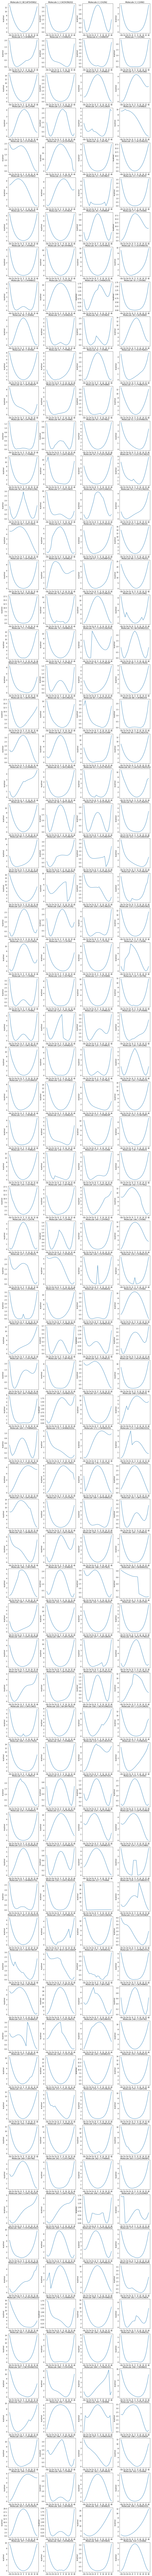

In [122]:
# For manual corner detection
good_indices = np.where(IS_GOOD_ENTRY)[0]
plot_scans(ENERGIES[good_indices], good_indices)

In [123]:
# Manualy determined plots with corners

# Large and noticeable - these are the ones that we definitely want to
# remove.
MANUAL_LARGE_CORNERS = [14,22,34,37,38,53,55,56,70,72,75,85,93,101,104,
                        106,114,120,125,134,136,144,149,150,151,168,172,
                        176,189,197,202,203,206,224,227,228,230,233,235,
                        240,243,244,258,266,267,273,281,289,291,293]
# We can probably live with these.
MANUAL_SMALL_CORNERS = [4,6,15,46,91,105,122,178,210,212,231,253,259,308]

print(f"{len(MANUAL_LARGE_CORNERS)} plots with large corners")
print(f"{len(MANUAL_SMALL_CORNERS)} plots with small corners")

50 plots with large corners
14 plots with small corners


In [124]:
def find_plots_with_corners(corner_difference_magnitude):
    """
    Detecting corners presents a slight challenge because we do not have
    continuous data. Here, we attempt to do it by checking if the left and
    right slopes at each point in the plot have opposite signs and differ by
    at least corner_difference_magnitude.
    
    Strictly speaking, corner_difference_magnitude is in units of
    (kcal/mol) / degree
    
    Returns the indices of plots that were detected as having corners.
    """
    has_corner = np.zeros(NUM_ENTRIES, dtype=bool)

    for idx, energy_series in enumerate(ENERGIES):
        if not IS_GOOD_ENTRY[idx]: continue
        for i in range(1, NUM_FRAMES - 1): # only cover frames with both left and right frame
            # Slope is the energy divided by the number of degrees (4)
            left_slope = (energy_series[i] - energy_series[i - 1]) / DEG_BTWN_FRAMES
            right_slope = (energy_series[i + 1] - energy_series[i]) / DEG_BTWN_FRAMES

            are_opposite_direction = \
                (left_slope < 0 and right_slope > 0) or \
                (left_slope > 0 and right_slope < 0)
            have_sufficient_difference = \
                abs(left_slope - right_slope) >= corner_difference_magnitude

            if are_opposite_direction and have_sufficient_difference:
                has_corner[idx] = True
                print(f"1D scan for molecule {idx:3} ({MOLECULES[idx].get_molecular_formula()}) has a corner")
                break # no need to check the rest of the plot

    num_plots_with_corners = int(np.sum(has_corner))
    print(f"{num_plots_with_corners} scans found with corners")
    corner_indices = np.where(has_corner)[0]
    plot_scans(ENERGIES[corner_indices], corner_indices)
    return corner_indices

1D scan for molecule  14 (C5H11NO4) has a corner
1D scan for molecule  22 (C4H3NO3) has a corner
1D scan for molecule  53 (C10H13N3O3) has a corner
1D scan for molecule  56 (BrC13F6H12NO) has a corner
1D scan for molecule  72 (C14H19N2) has a corner
1D scan for molecule  75 (C15FH11N2O4S) has a corner
1D scan for molecule  85 (C20H21N3O4S) has a corner
1D scan for molecule 101 (C5H14NO5PS) has a corner
1D scan for molecule 104 (C8H18NO3PS) has a corner
1D scan for molecule 114 (C3H9N) has a corner
1D scan for molecule 120 (C4H12NOP) has a corner
1D scan for molecule 149 (C5ClH5N4O2) has a corner
1D scan for molecule 150 (C5H6N2O2S) has a corner
1D scan for molecule 168 (CH5NO3S) has a corner
1D scan for molecule 172 (C6H10N2O2S2) has a corner
1D scan for molecule 176 (C3H11N2) has a corner
1D scan for molecule 202 (C13H13NO3S) has a corner
1D scan for molecule 206 (C8ClH10NO2S2) has a corner
1D scan for molecule 224 (C12H11N6O) has a corner
1D scan for molecule 227 (C7H4N4) has a corne

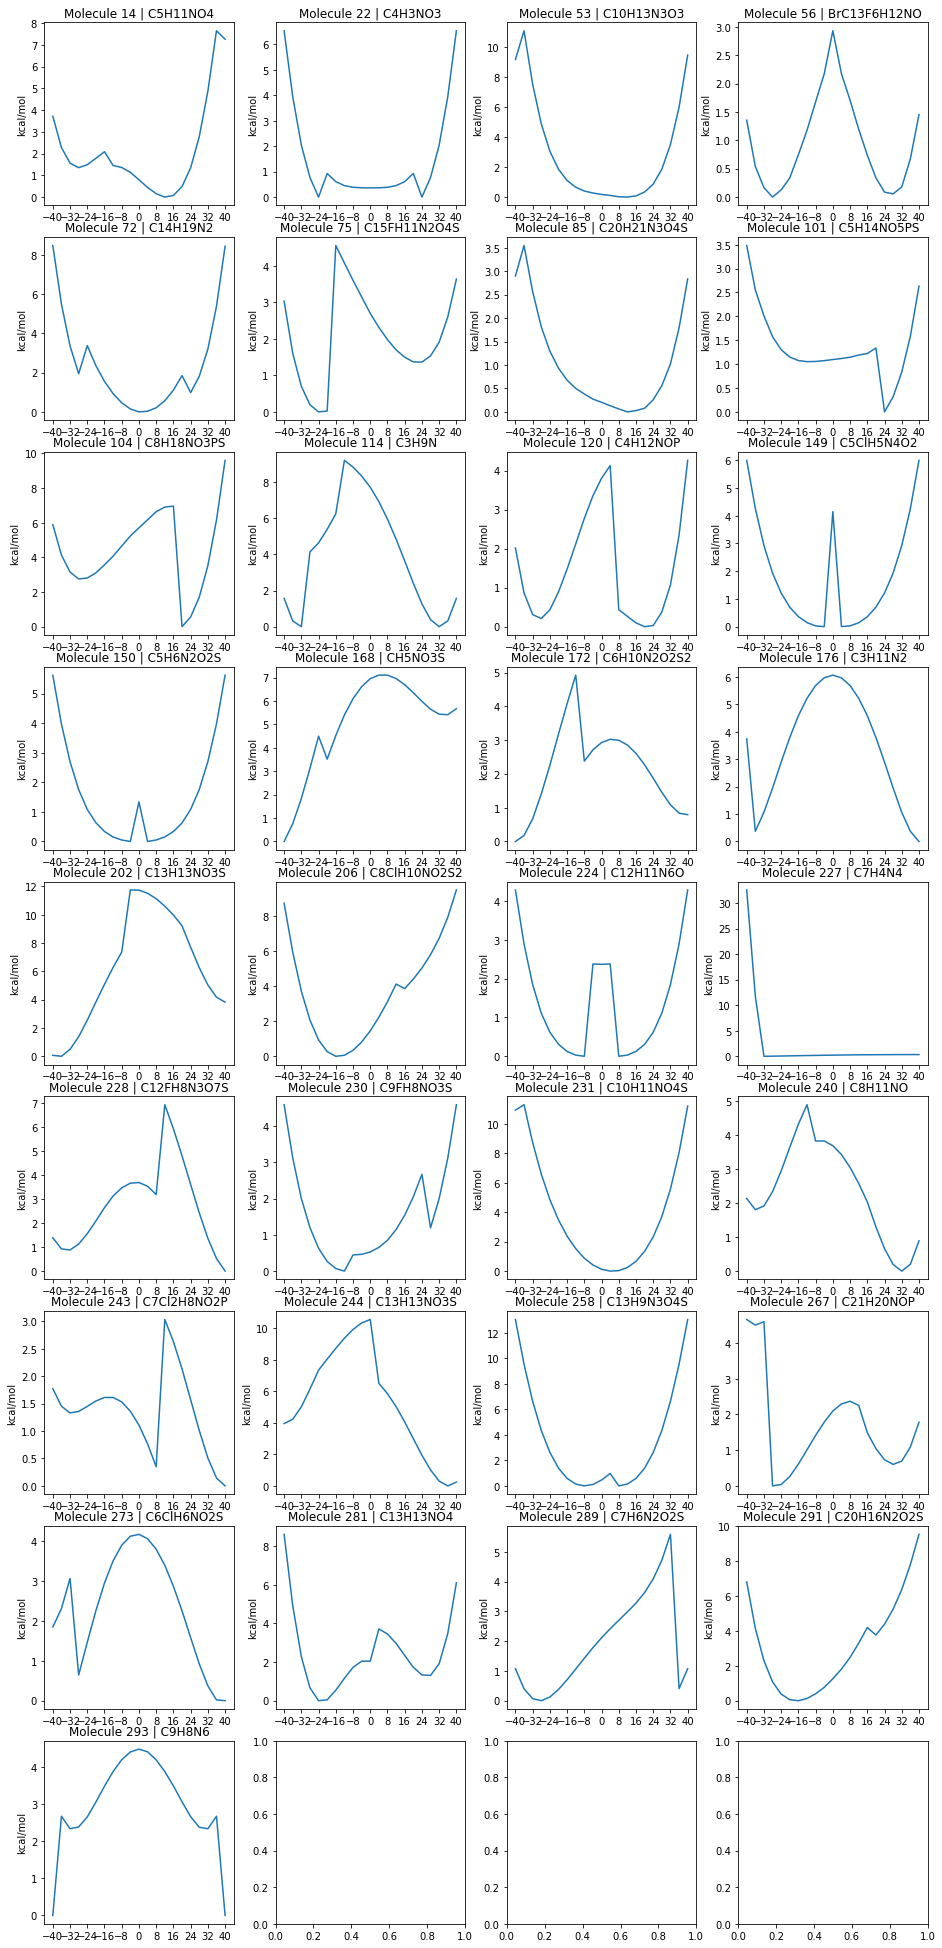

In [126]:
CORNER_INDICES = find_plots_with_corners(0.3000)

18 corner(s) detected manually but not automatically: {34, 37, 134, 38, 136, 197, 266, 70, 203, 233, 106, 235, 144, 93, 55, 125, 151, 189}


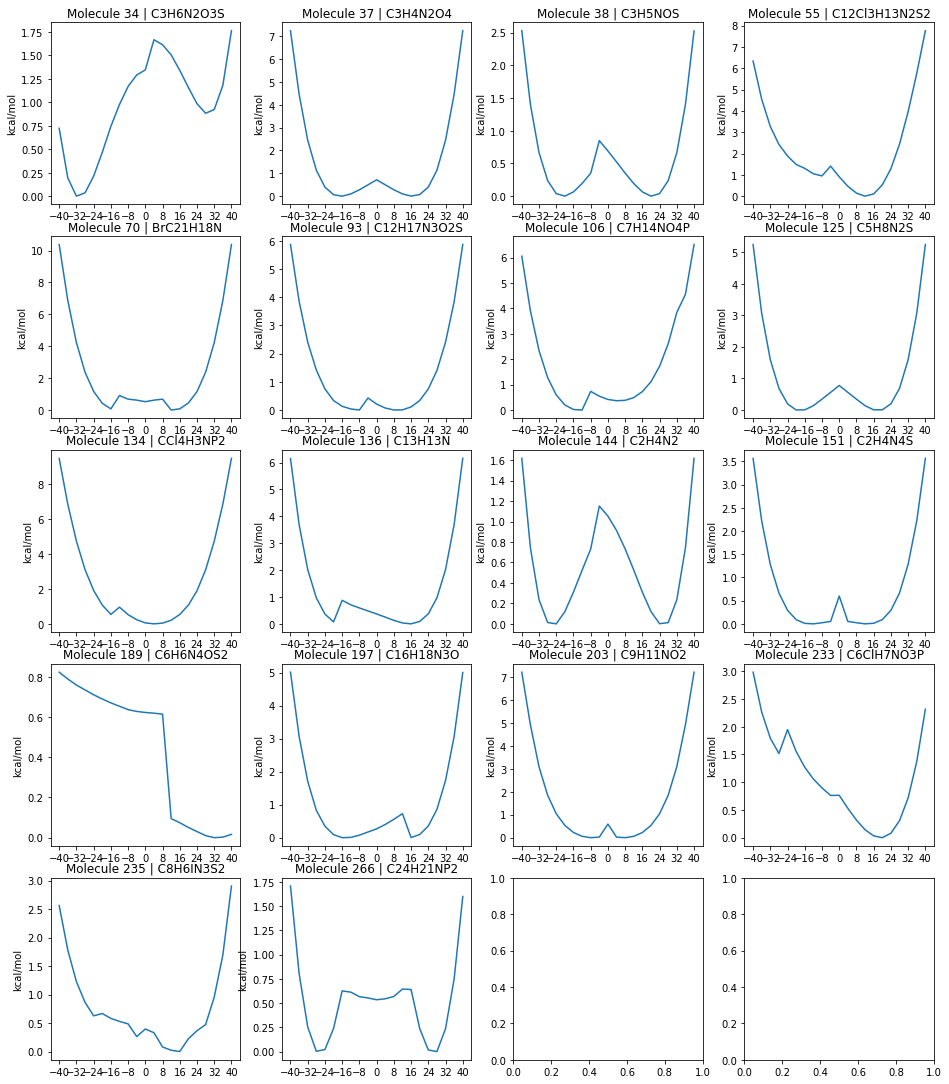

1 corner(s) detected automatically but not manually: {231}


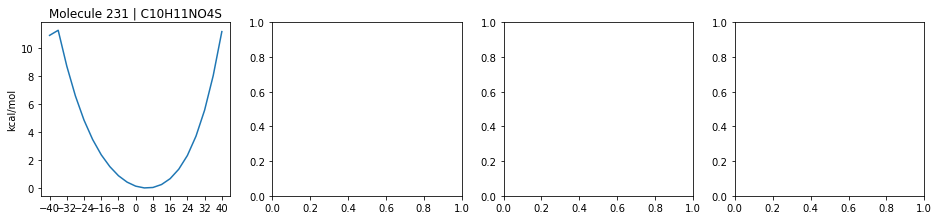

In [127]:
# Compare the indices found to the ones manually selected - we want to stick
# with the automatically generated indices because they are reproducible.
# In general, we want higher precision - i.e. we want to avoid false negatives
# because those take away data that we could use.

automatic_corners = set(CORNER_INDICES)
manual_corners = set(MANUAL_LARGE_CORNERS)

manual_but_not_automatic = manual_corners - automatic_corners
m_not_a_indices = np.array(sorted(manual_but_not_automatic))

automatic_but_not_manual = automatic_corners - manual_corners
a_not_m_indices = np.array(sorted(automatic_but_not_manual))

print(f"{len(manual_but_not_automatic)} corner(s) detected manually but "
      f"not automatically: {manual_but_not_automatic}")
plot_scans(ENERGIES[m_not_a_indices], m_not_a_indices)

print(f"{len(automatic_but_not_manual)} corner(s) detected automatically "
      f"but not manually: {automatic_but_not_manual}")
plot_scans(ENERGIES[a_not_m_indices], a_not_m_indices)

In [129]:
# Mark the plots with (automatically detected) corners as bad
mark_bad_indices(CORNER_INDICES)

## Visualization

Get a better idea of what the data looks like using PCA.

In [ ]:
# Apply PCA to reduce to 2d for plotting
pca_2d = decomposition.PCA(n_components=2)
ENERGIES_2D = pca_2d.fit_transform(ENERGIES[np.where(IS_GOOD_ENTRY)])

In [ ]:
def pca_plot(cluster_ids=None):
    """Create a plot of the PCA.
    
    When one hovers over the points, they can see the normalized 1D
    scan for it, as well as the index and molecular formula.
    |cluster_ids| is an array such that cluster_ids[i] is the cluster id
    of molcule i.
    """
    %matplotlib notebook
    
    if cluster_ids is None:
        cluster_ids = np.zeros(len(GOOD_ENTRIES))
    fig, ax = plt.subplots(1,2,figsize=(10, 4))
    pca_ax = ax[0]  # Scatterplot of the energies after 2D PCA
    scan_ax = ax[1] # 1D scan of molecule energies
    
    scatter_path = pca_ax.scatter(ENERGIES_2D[:,0],
                                  ENERGIES_2D[:,1],
                                  c=cluster_ids,
                                  cmap=matplotlib.cm.get_cmap("tab20c"))
    pca_ax.set_title("2D PCA of Grid Optimization Energies")

    def show_plot(event):
        """
        A callback that handles mouse events and shows the molecule
        in the plot.
        """
        mouse_hovering, info = scatter_path.contains(event)
        if mouse_hovering:
            # Index within the scatter plot points where the mouse hovers.
            index, = info["ind"]
            # Set the 1D scan plot to correspond to the point.
            scan_ax.clear()
            plot_1d_scan(scan_ax, index)
        fig.canvas.draw_idle()
    # Add the callback.
    fig.canvas.mpl_connect('motion_notify_event', show_plot)

    plt.show()

In [ ]:
# Rerun if interactivity not working
pca_plot()

## Clustering
Clustering the molecules by energy profile.

In [ ]:
def cluster_ids_to_clusters(cluster_ids):
    """Get a list where entry i lists the molecules in cluster i."""
    num_clusters = len(set(cluster_ids))
    clusters = [[] for _ in range(num_clusters)]
    for mol_idx,cid in enumerate(cluster_ids):
        clusters[cid].append(mol_idx)
    return clusters

def get_clusters(n_clusters=10):
    """Get the ids and clusters from clustering with n clusters.
    
    Indices correspond to molecules in GOOD_ENTRIES.
    """
    # Tells the cluster id of every molecule in GOOD_ENTRIES
    cluster_ids = AgglomerativeClustering(n_clusters=n_clusters,
                                          affinity="euclidean",
                                          linkage="ward").fit_predict(ENERGIES)
    return cluster_ids, cluster_ids_to_clusters(cluster_ids)

def plot_details_for_clusters(clusters):
    """Plot the 1D scans and other details of molecules in each cluster."""
    COLS = 4
    FIG_WIDTH = 13
    PLOT_HEIGHT = 3
    %matplotlib inline

    for cid,cluster in enumerate(clusters):
        display(HTML(f"<h1>Cluster {cid}</h1>"))
        rows = math.ceil(len(clusters[cid]) / COLS)
        fig, ax = plt.subplots(rows, COLS, figsize=(FIG_WIDTH, PLOT_HEIGHT * rows))
        fig.tight_layout() # Improve spacing between plots
        ax = np.atleast_2d(ax)

        idx = 0
        for r in range(rows):
            for c in range(COLS):
                if idx < len(cluster):
                    plot_1d_scan(ax[r,c], cluster[idx])
                idx += 1
        plt.show()

In [ ]:
cluster_ids, clusters = get_clusters(30) # Modify number of clusters as needed

In [ ]:
pca_plot(cluster_ids)

In [ ]:
plot_details_for_clusters(clusters)